In [20]:
import clinical_model as cmod

In [21]:
mod = cmod.Clinical_model("/Users/pascal/Desktop/Python/trou_maculaire/data/")

In [22]:
mod.entrainement_de_base()
mod.afficher_courbe_ROC()

AttributeError: 'Clinical_model' object has no attribute 'entrainement_de_base'

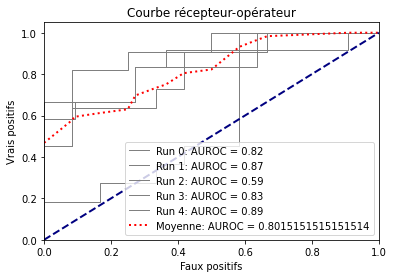

RuntimeError: Tentative d'entrainer un modèle dont les données ne sont pas traitées.

In [16]:
mod.reinitialiser_le_modele("crossvalidation")
cval_stats = []
for i in range(5):
    mod.crossval_model()
    mod.afficher_courbe_ROC()
    cval_stats.append(mod.stats[i])

In [13]:
mod.reinitialiser_le_modele("base")
mod.entrainement_de_base()
mod.afficher_courbe_ROC()

TypeError: reinitialiser_le_modele() takes 1 positional argument but 2 were given